In [1]:
# libraries
from PyQt5.QtWidgets import *
from PyQt5.QtGui import QIcon, QPixmap, QImage, QPainter, QPen # icon and load image
from PyQt5.QtCore import Qt, QPoint

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg # load image

import cv2 # open-cv use for image resize

## Convolutional Neural Network

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import utils as np_utils

import sys
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## 1-Preprocess

In [ ]:
(x_train, y_train),(x_test, y_test) = mnist.load_data()

In [ ]:
plt.figure()
i = 55
plt.imshow(x_train[i], cmap = "gray")
print("Label: ",y_train[i])
plt.axis("off") #resim göstereceğim için eksenleri kapatmak istiyorum
plt.grid(False) #resim göstereceğim için plotumun üzerinde gridler olsun istemiyorum.

In [ ]:
x_train.shape # rgb için 3, tek renk için 1 yazılmalı. Biz bu projede tek renk çalışacağız.

#### **Keras** **shape(60000, 28, 28, 1)** yapısını kabul ediyor. O yüzden sonuna renk ekleriz. Boyutta bir değişiklik yapmayacağız.

In [ ]:
# x_train = x_train.reshape( x_train.shape[0], x_train.shape[1],x_train.shape[2], 1)
# x_test = x_test.reshape( x_test.shape[0], x_test.shape[1], x_test.shape[2],1)
# input_shape = (x_train.shape[1],x_train.shape[2], 1)
img_rows = 28
img_cols = 28
x_train = x_train.reshape( x_train.shape[0],img_rows,img_cols,1)
x_test = x_test.reshape( x_test.shape[0],img_rows,img_cols,1)
input_shape = (img_rows,img_cols,1)

## 2-Normalization

Note
Bilgi kaybetmemek adına, verileri float formatında cast ediyoruz ki her bir basamak değeri bizim için önemli diye ! :)

In [ ]:
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")

- Normalization ile verilerimizi [0, 1] arasına sıkıştırmış oluyoruz. 

- 0 ve 1 arasına dönüştürmek için, 255'e böleriz bunun sebebi siyah renk 0, beyaz renk 255 olarak ifade edilir. 
- 0 en küçük 255 en büyük sayıya karşılık renk olduğu için 0 ile 1'e dönüştürmek için 255'e böleriz.

In [ ]:
x_train /= 255 # x_train = x_train/255
x_test /= 255

**y_train** ve **y_test** değerlerini eğitimde kullanabilmek için categorical hale getirmem gerekiyor.
One hot encoding metodunu kullanabiliriz. 

0 => 0000000000

1 => 0100000000

*

*

9 => 0010000001

In [ ]:
target_class_count = 10
y_train = np_utils.to_categorical(y_train, target_class_count)
y_test = np_utils.to_categorical(y_test, target_class_count)


## 3-CNN

In [ ]:
model_list = []
score_list = []
batch_size = 64
epochs = 5

#### Modeller arasında farklıklar: İlk model 16, 32 ve 64 nörondan oluşan 3 layerdan, ikinci model 8, 16, ve 32 nöronlara sahip layerlardan oluşur.

In [ ]:
filter_numbers = np.array([[16, 32, 64], 
                           [8, 16, 32]])

In [ ]:
for i in range(2): # 2 adet modelimiz var
    
    print(filter_numbers[i])

    model = Sequential()
    
    model.add(Conv2D(filter_numbers[i,0], kernel_size = (3,3), activation = "relu",input_shape = input_shape))
    model.add(Conv2D(filter_numbers[i,1], kernel_size = (3,3), activation = "relu"))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(0.25)) # 4te 1 oranında nöronları söndürecek.
    
    model.add(Flatten())

    model.add(Dense(filter_numbers[i,2], activation = "relu")) 
    model.add(Dropout(0.5))
    model.add(Dense(target_class_count, activation = "softmax")) # output layer
    
    # COMPILING THE MODEL

    model.compile(loss = keras.losses.categorical_crossentropy, optimizer = keras.optimizers.Adadelta(), metrics = ["accuracy"])
    
    # TRAINING THE MODEL
    history = model.fit(x_train, 
                        y_train, 
                        batch_size = batch_size, 
                        epochs = epochs, 
                        verbose = 1,
                        validation_data = (x_test, y_test))

    # Normalde validation kısmında x_test, y_test kullanmış olsak da, modelin testini yine x_test ve y_test dataseti ile yapacağız. Normalde bunu ayrı yapmak gerekirdi. Şu an için gerek yok. Çünkü bu modelin çalışıp çalışmadığını kendi kullanıcı arayüzüne yazacağımız sayılardan anlayacağız.

    # TESTING THE MODEL
    score = model.evaluate(x_test, y_test, verbose = 0) # verbose = 0 görek istemiyoruz.
    print("Model {} Test Loss: {}".format(i+1, score[0]))
    print("Model {} Test Accuracy: {}".format(i+1, score[1]))

    # SAVE THE MODEL
    model_list.append(model) # modelimizi depolarız.
    score_list.append(score) # score larımızı depolarız.
    
    model.save("model"+str(i+1)+".h5") # model1.h5

In [2]:
model1 = load_model("model1.h5")
model2 = load_model("model2.h5")

## 4-GUI

### Canvas
Çizilen sayının siyah kısımları(arka plan) 0, beyaz kısımları 1 olacak

In [3]:
class Canvas(QMainWindow):
    
    def __init__(self):
        super().__init__()
        
        self.width = 400
        self.height = 400
        self.setWindowTitle("Draw Digit App")
        self.setGeometry(50, 100, self.width, self.height)
        
        self.image = QImage(self.size(), QImage.Format_RGB32) #QImage ile boş bir image alanı ekleniyor.
        self.image.fill(Qt.black)
        
        self.lastPoint = QPoint()
        self.drawing = False # başlangıçta çiziyoruz.
        
        # image_array
        self.im_np = np.zeros([self.width, self.height])
        
        button1 = QPushButton("Ok!", self)
        button1.move(2,2)
        button1.clicked.connect(self.enterFunction)
        
        self.show()
        
    def paintEvent(self,event):
        canvasPainter = QPainter(self)
        canvasPainter.drawImage(self.rect(),self.image, self.image.rect())
        
    def enterFunction(self):
        ptr = self.image.constBits()
        ptr.setsize(self.image.byteCount())
        
        self.im_np = np.array(ptr).reshape(self.width, self.height, 4)
        self.im_np = self.im_np[:,:,0] # rgb renklerinden birini almak yeterli(tek renk çünkü), 0'ı aldık.
        self.im_np = self.im_np/255.0 # normalize ettik. rgb için normalize (255,255,255)/255
        
        if np.sum(self.im_np) == 0: # her yer siyahsa => siyah=0, beyaz=255
            print("Please write a digit")
        else: #bir şeyler yazdıysak (beyaz bir şey)
            plt.figure(figsize = (1,1),dpi = 200)
            plt.imshow(self.im_np, cmap = "gray") # bir de biz görelim bir şey yazdık mı?
            plt.axis("off")
            plt.grid(False)
            plt.savefig("input_img.png") # çizdiğimiz resmi kaydedediriz.
            
            self.close() # bu işlemler sonrası canvas windowu kapatabiliriz.
            
    def mousePressEvent(self,event): # butona basıldıysa(sol butonla)
        
        if event.button() == Qt.LeftButton:
            self.lastPoint = event.pos() # bastığım noktanın pozisyonunu al,lastPointe eşitle
            self.drawing = True # çizme işlemi başladı
            print(self.lastPoint)
        
    def mouseMoveEvent(self,event): # butona basılmış ve çizmeye başlandıysa
        if (event.buttons() == Qt.LeftButton) & self.drawing: #basılı tutulduğunda, butona birden fazla tıklanmış gibi algılar. O yüzden buttons => çoğul
            painter = QPainter(self.image)
            painter.setPen(QPen(Qt.white,20,Qt.SolidLine,Qt.RoundCap,Qt.RoundJoin)) #çizim
            painter.drawLine(self.lastPoint, event.pos())
            self.lastPoint = event.pos()
            self.update()
            
    def mouseReleaseEvent(self, event):
        if event.button == Qt.LeftButton: # çizme işlemi bittiyse
            self.drawing = False

### Window

In [4]:
class Window(QMainWindow):
    
    def __init__(self): # constructor
        super().__init__() 
        
        # main window
        self.width = 1080
        self.height = 640
        
        self.setWindowTitle("Digit Classification")
        self.setGeometry(50,100,self.width, self.height) #50,100 windowun default açılacağı location
        self.setWindowIcon(QIcon("icon-hi.png"))
        
        self.create_canvas = Canvas()
        
        self.tabWidget()
        self.widgets()
        self.layouts()
        self.show() # yapılanları görselleştirmek için
        
    def tabWidget(self):
        self.tabs = QTabWidget()
        self.setCentralWidget(self.tabs)
        
        self.tab1 = QWidget()
        self.tab2 = QWidget()

        self.tabs.addTab(self.tab1, "Classification")
        self.tabs.addTab(self.tab2, "Parameters")

    def widgets(self):
        
        # tab1 left
        self.drawCanvas = QPushButton("Draw Canvas")
        self.drawCanvas.clicked.connect(self.drawCanvasFunction)
        
        self.openCanvas = QPushButton("Open Canvas")
        self.openCanvas.clicked.connect(self.openCanvasFunction)

        self.inputImage = QLabel(self)
        self.inputImage.setPixmap(QPixmap("input.png")) # çizdiğimiz resmin ismi
        
        self.searchText = QLabel("Real number: ")
        
        self.searchEntry = QLineEdit()
        self.searchEntry.setPlaceholderText("Which number do you write?")

        # tab1 left middle
        self.methodSelection = QComboBox(self)
        self.methodSelection.addItems(["model1","model2"])
        
        # Güzel bir sayı çizdik ama ona gürültü eklediğimizde de o sayı ne tanıyabilecek mi?
        self.noiseText = QLabel("Add Noise: % " + "0")
        self.noiseSlider = QSlider(Qt.Horizontal)
        self.noiseSlider.setMinimum(0)
        self.noiseSlider.setMaximum(100)
        self.noiseSlider.setTickPosition(QSlider.TicksBelow)
        self.noiseSlider.setTickInterval(1)
        self.noiseSlider.valueChanged.connect(self.noiseSliderFunction)
        
        self.remember = QCheckBox("Save Result",self)
        
        self.predict = QPushButton("Predict")
        self.predict.clicked.connect(self.predictionFunction)
        
        # tab1 right middle
        self.outputImage = QLabel(self)
        self.outputImage.setPixmap(QPixmap("icon-hi.png")) # bir resmi yüklemek için
        
        self.outputLabel = QLabel("",self) # başlangıçta output yok
        self.outputLabel.setAlignment(Qt.AlignCenter)
        
        # tab1 right
        self.resultTable = QTableWidget()
        self.resultTable.setColumnCount(2)
        self.resultTable.setRowCount(10)
        self.resultTable.setHorizontalHeaderItem(0, QTableWidgetItem("Label(Class)"))
        self.resultTable.setHorizontalHeaderItem(1, QTableWidgetItem("Probability"))
        
        # tab2 method1
        self.parameter_list1  = QListWidget(self)
        self.parameter_list1.addItems(["batch_size = 256","epochs = 5","img_rows = 28",
                                       "img_cols = 28","Filter # = [16,32,64]","Activation Function = Relu",
                                       "loss = categorical cross entropy",
                                       "optimizer = Adadelta","metrics = accuracy"])
        
        # tab2 method2
        self.parameter_list2  = QListWidget(self)
        self.parameter_list2.addItems(["batch_size = 256","epochs = 5","img_rows = 28",
                                       "img_cols = 28","Filter # = [8,16,32]","Activation Function = Relu",
                                       "loss = categorical cross entropy",
                                       "optimizer = Adadelta","metrics = accuracy"])


    def predictionFunction(self):
        save_string = ""
        
        real_entry = self.searchEntry.text() # 
        save_string = save_string + " real entry: "+str(real_entry) + ", " #real number'a girdiğim değerleri depolarım.
        
        # CNN model selection
        model_name = self.methodSelection.currentText()
        
        if model_name == "model1":
            model = load_model("model1.h5")
        elif model_name == "model2":
            model = load_model("model2.h5")
        else:
            print("Error")
            
        save_string = save_string + "model name: "+str(model_name) + ", "
        
        # slider noise => işlemi zorlaştımak, resmi bozmak istiyoruz
        
        noise_val = self.noiseSlider.value()
        
        # Ornek: noise_value 50 seçilsin. Sonra 0 ile 50 arasında 28x28 (CNN bu boyutta resimlerle çalışsın demiştik) matris şeklinde noise değerleri üretilecek. daha sonra bunu 100'e bölerek normalize et (0,1 arasında olsun) diyoruz.
        if noise_val != 0:
            noise_array = np.random.randint(0, noise_val, (28, 28)) / 100
        else:
            noise_array = np.zeros([28,28]) # noise yok hepsi 0 olan bir array yaratırız
            
        save_string = save_string + "noise value: " + str(noise_val) + ", "
        print(save_string)

        # load image as numpy
        img_array = mpimg.imread("input_img.png")[26:175, 26:175, 0] # 0,26 arası boş sayfa olarak görülüyor istemsiz. Bu yüzden 26dan başlatırız
        
        resized_img_array = cv2.resize(img_array, dsize=(28,28),interpolation = cv2.INTER_CUBIC) #resmi 28x28e küçültürüz.
        
        # add noise
        resized_img_array = resized_img_array + noise_array
        
        # vis noise image
        plt.imshow(resized_img_array, cmap = "gray")
        plt.title("image after adding noise and resize")
        
        # predict
        result = model.predict(resized_img_array.reshape(1,28,28,1))
        QMessageBox.information(self,"Information","Classification is completed.")
        predicted_class = np.argmax(result)
        print("Prediction: ",predicted_class)
        
        save_string = save_string + "Predicted class: "+str(predicted_class)
        
        # save result
        if self.remember.isChecked():
            text_file = open("Output.txt","w")
            text_file.write(save_string)
            text_file.close()
        else:
            print("not save")
        
        # output image and its text
        self.outputImage.setPixmap(QPixmap("img\\"+str(predicted_class)+".png"))
        self.outputLabel.setText("Real: "+str(real_entry)+ " and Predicted: "+str(predicted_class))
        
        # set result
        for row in range(10):
            self.resultTable.setItem(row,0,QTableWidgetItem(str(row)))
            self.resultTable.setItem(row,1,QTableWidgetItem(str(np.round(result[0][row],5))))
        
    def drawCanvasFunction(self):
        self.create_canvas.show()
        
    def openCanvasFunction(self): # çizilen kaydedilen resmi açma.
        self.inputImage.setPixmap(QPixmap("input_img.png"))
    
    def noiseSliderFunction(self):
        val = self.noiseSlider.value()
        self.noiseText.setText("Add Noise: % " + str(val))
    
    def layouts(self):
        
        # tab1 layout
        self.mainLayout = QHBoxLayout()
        self.leftLayout = QFormLayout()
        self.leftMiddleLayout = QFormLayout()
        self.rightMiddleLayout = QFormLayout()
        self.rightLayout = QFormLayout()
    
        # left
        self.leftLayoutGroupBox = QGroupBox("Input Image")
        self.leftLayout.addRow(self.drawCanvas)
        self.leftLayout.addRow(self.openCanvas)
        self.leftLayout.addRow(self.inputImage)
        self.leftLayout.addRow(self.searchText)
        self.leftLayout.addRow(self.searchEntry)
        self.leftLayoutGroupBox.setLayout(self.leftLayout)
        
        # left middle
        self.leftMiddleLayoutGroupBox = QGroupBox("Settings")
        self.leftMiddleLayout.addRow(self.methodSelection)
        self.leftMiddleLayout.addRow(self.noiseText)
        self.leftMiddleLayout.addRow(self.noiseSlider)
        self.leftMiddleLayout.addRow(self.remember)
        self.leftMiddleLayout.addRow(self.predict)
        self.leftMiddleLayoutGroupBox.setLayout(self.leftMiddleLayout)
    
        # right middle 
        self.rightMiddleLayoutGroupBox = QGroupBox("Output")
        self.rightMiddleLayout.addRow(self.outputImage)
        self.rightMiddleLayout.addRow(self.outputLabel)
        self.rightMiddleLayoutGroupBox.setLayout(self.rightMiddleLayout)
    
        # right 
        self.rightLayoutGroupBox = QGroupBox("Result")
        self.rightLayout.addRow(self.resultTable)
        self.rightLayoutGroupBox.setLayout(self.rightLayout)
    
        # tab1 main layout
        self.mainLayout.addWidget(self.leftLayoutGroupBox,25)
        self.mainLayout.addWidget(self.leftMiddleLayoutGroupBox,25)
        self.mainLayout.addWidget(self.rightMiddleLayoutGroupBox,25)
        self.mainLayout.addWidget(self.rightLayoutGroupBox,25)
        self.tab1.setLayout(self.mainLayout)
        
        # tab2 layout
        self.tab2Layout = QHBoxLayout()
        self.tab2Method1Layout = QFormLayout()
        self.tab2Method2Layout = QFormLayout()
        
        # tab2 Method1 Layout
        self.tab2Method1LayoutGroupBox = QGroupBox("Method1")
        self.tab2Method1Layout.addRow(self.parameter_list1)
        self.tab2Method1LayoutGroupBox.setLayout(self.tab2Method1Layout)
        
        # tab2 Method2 Layout
        self.tab2Method2LayoutGroupBox = QGroupBox("Method2")
        self.tab2Method2Layout.addRow(self.parameter_list2)
        self.tab2Method2LayoutGroupBox.setLayout(self.tab2Method2Layout)
    
        # tab2 main layout
        self.tab2Layout.addWidget(self.tab2Method1LayoutGroupBox, 50)
        self.tab2Layout.addWidget(self.tab2Method2LayoutGroupBox, 50)
        self.tab2.setLayout(self.tab2Layout)

PyQt5.QtCore.QPoint(194, 81)
 real entry: 1, model name: model1, noise value: 0, 
Prediction:  1
not save
PyQt5.QtCore.QPoint(189, 74)
PyQt5.QtCore.QPoint(148, 208)
 real entry: 1, model name: model1, noise value: 0, 
Prediction:  6
not save
 real entry: 1, model name: model2, noise value: 0, 
Prediction:  3
not save


0

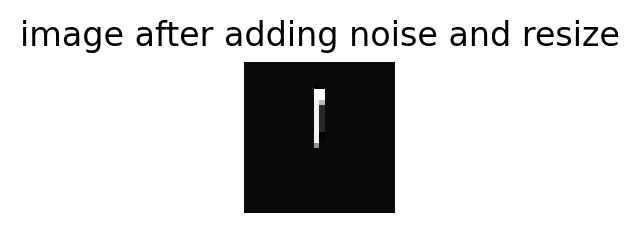

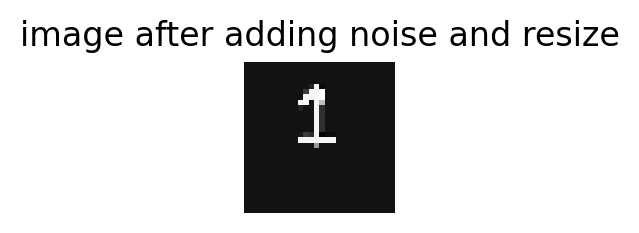

In [5]:
app = QApplication(sys.argv)
w = Window()
w.show()
app.exec()